In [1]:
#Data manipulation
import pandas as pd
import numpy as np
#Plots
import matplotlib.pyplot as plt
import seaborn as sns
#Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
#Models
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
#Scores
from sklearn.model_selection import train_test_split, cross_val_score, TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error

# 1 - EDA and preprocessing

In [2]:
train=pd.read_csv("train.csv")
test=pd.read_csv("test.csv")
stores=pd.read_csv("stores.csv")
features=pd.read_csv("features.csv")

In [3]:
print("Train:",train.shape)
print("Test:",test.shape)
print("Stores:",stores.shape)
print("Features:",features.shape)

Train: (421570, 5)
Test: (115064, 4)
Stores: (45, 3)
Features: (8190, 12)


## 1.1 - Joining tables
- **Stores**: indicates the type and size of stores
- **Features**: indicates some characteristics for every day

In [4]:
train=train.merge(stores,on="Store")
test=test.merge(stores,on="Store")

In [5]:
train=pd.merge(train, features, how='left', on=["Store", "Date"])
test=pd.merge(test, features, how='left', on=["Store", "Date"])

In [6]:
train.drop("IsHoliday_y",axis=1,inplace=True)
test.drop("IsHoliday_y",axis=1,inplace=True)

In [7]:
train.rename(columns={"IsHoliday_x":"IsHoliday"},inplace=True)
test.rename(columns={"IsHoliday_x":"IsHoliday"},inplace=True)

In [8]:
train.head(5)

,Store,Dept,Date,Weekly_Sales,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2010-02-05,24924.50,False,A,151315,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106
1,1,1,2010-02-12,46039.49,True,A,151315,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106
2,1,1,2010-02-19,41595.55,False,A,151315,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106
3,1,1,2010-02-26,19403.54,False,A,151315,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106
4,1,1,2010-03-05,21827.90,False,A,151315,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106


In [9]:
test.head(5)

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment
0,1,1,2012-11-02,False,A,151315,55.32,3.386,6766.44,5147.70,50.82,3639.90,2737.42,223.462779,6.573
1,1,1,2012-11-09,False,A,151315,61.24,3.314,11421.32,3370.89,40.28,4646.79,6154.16,223.481307,6.573
2,1,1,2012-11-16,False,A,151315,52.92,3.252,9696.28,292.10,103.78,1133.15,6612.69,223.512911,6.573
3,1,1,2012-11-23,True,A,151315,56.23,3.211,883.59,4.17,74910.32,209.91,303.32,223.561947,6.573
4,1,1,2012-11-30,False,A,151315,52.34,3.207,2460.03,NaN,3838.35,150.57,6966.34,223.610984,6.573


I need to build this column only for the submission file

In [10]:
submission=pd.DataFrame()
submission["Id"]=test["Store"].astype(str)+"_"+test["Dept"].astype(str)+"_"+test["Date"].astype(str)

In [11]:
print("Train data range is between {0} and {1}".format(train["Date"].min(), test["Date"].max()))
print("----------------------------------------------------------")
print("Train days = {0}".format(pd.to_datetime(train["Date"]).max() - pd.to_datetime(train["Date"]).min()))
print("----------------------------------------------------------\n\n")
print("Predict range is between {0} and {1}".format(test["Date"].min(), test["Date"].max()))
print("----------------------------------------------------------")
print("Predict days = {0}".format(pd.to_datetime(test["Date"]).max() - pd.to_datetime(test["Date"]).min()))

Train data range is between 2010-02-05 and 2013-07-26
----------------------------------------------------------
Train days = 994 days 00:00:00
----------------------------------------------------------


Predict range is between 2012-11-02 and 2013-07-26
----------------------------------------------------------
Predict days = 266 days 00:00:00


## 1.2 - Types

In [12]:
train.dtypes

Store             int64
Dept              int64
Date             object
Weekly_Sales    float64
IsHoliday          bool
Type             object
Size              int64
Temperature     float64
Fuel_Price      float64
MarkDown1       float64
MarkDown2       float64
MarkDown3       float64
MarkDown4       float64
MarkDown5       float64
CPI             float64
Unemployment    float64
dtype: object

- Change Date to datetime
- Change IsHoliday to 1 and 0

In [13]:
train["Date"]=pd.to_datetime(train["Date"])
test["Date"]=pd.to_datetime(test["Date"])

In [14]:
train["IsHoliday"]=np.where(train["IsHoliday"]==True,1,0)
test["IsHoliday"]=np.where(test["IsHoliday"]==True,1,0)

## 1.3 - Categorical features

### 1.3.1 - Store, type and size

Store

In [15]:
train["Store"].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45])

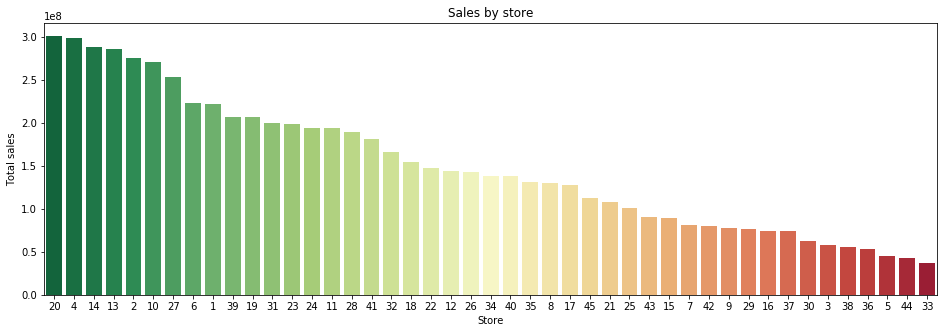

In [16]:
sales_by_store=train.groupby("Store")["Weekly_Sales"].sum().reset_index(name="Total sales").sort_values(by="Total sales",ascending=False)
plt.figure(figsize=(16,5))
sns.barplot(sales_by_store["Store"],sales_by_store["Total sales"],palette="RdYlGn_r",order=sales_by_store["Store"].tolist())
plt.title("Sales by store")
plt.show()

In [17]:
sales_by_store["Cum Sales"]=sales_by_store["Total sales"].cumsum()
sales_by_store["Pct sales"]=sales_by_store["Cum Sales"]/train["Weekly_Sales"].sum()
stores_eighty_pct_sales=sales_by_store[sales_by_store["Pct sales"]<=0.81]["Store"].tolist()
print("The first {0} stores plotted represents the 80% of the total sales".format(len(stores_eighty_pct_sales)))

The first 27 stores plotted represents the 80% of the total sales


In [18]:
train.groupby("Store")["Weekly_Sales"].sum().reset_index(name="Sales by store").set_index("Store").describe()

,Sales by store
count,4.500000e+01
mean,1.497160e+08
std,7.816756e+07
min,3.716022e+07
25%,7.956575e+07
50%,1.382498e+08
75%,1.996139e+08
max,3.013978e+08


Type

In [19]:
train["Type"].value_counts()/train["Type"].count()*100

A    51.113220
B    38.782409
C    10.104372
Name: Type, dtype: float64

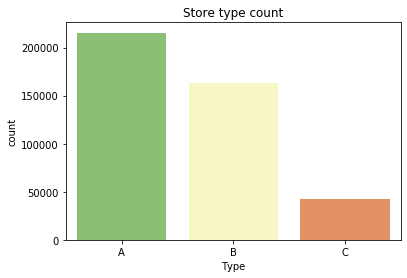

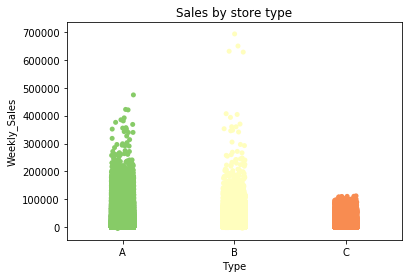

In [20]:
sns.countplot(train["Type"],palette="RdYlGn_r")
plt.title("Store type count")
plt.show()

sns.stripplot(train["Type"],train["Weekly_Sales"],palette="RdYlGn_r")
plt.title("Sales by store type")
plt.show()

In [21]:
train.groupby("Type")["Size"].describe()

,count,mean,std,min,25%,50%,75%,max
Type,,,,,,,,
A,215478.0,182231.285486,41534.529330,39690.0,158114.0,202505.0,203819.0,219622.0
B,163495.0,101818.735827,30921.779415,34875.0,93188.0,114533.0,123737.0,140167.0
C,42597.0,40535.725286,1194.434302,39690.0,39690.0,39910.0,41062.0,42988.0


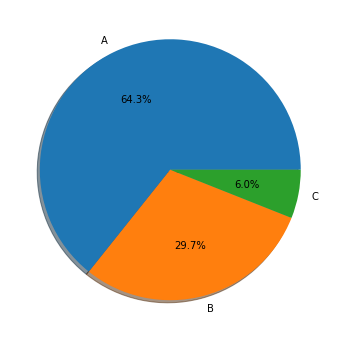

In [22]:
types_pct=(train.groupby("Type")["Weekly_Sales"].sum()/train["Weekly_Sales"].sum()*100).reset_index(name="%")
plt.figure(figsize=(6,6))
plt.pie(types_pct["%"],labels=types_pct["Type"],autopct="%1.1f%%",shadow=True)
plt.show()

- We see that there are more type A stores (51%) and C has the least quantity of stores (10%)
- The stores that sells the most are type B, and the least type C
- The type A sells 64% of the total sales, 30% B type and only a 6% C type
- The type C has a very uniform size, but A and B don't, so we can create a Size feature (Big,medium,small) in order to improve our model accuracy

### 1.3.2 - Dept

In [23]:
print("There are {0} departaments".format(len(train["Dept"].unique())))

There are 81 departaments


In [24]:
sales_by_dept=train.groupby("Dept")["Weekly_Sales"].sum().reset_index(name="Total sales").sort_values(by="Total sales",ascending=False)

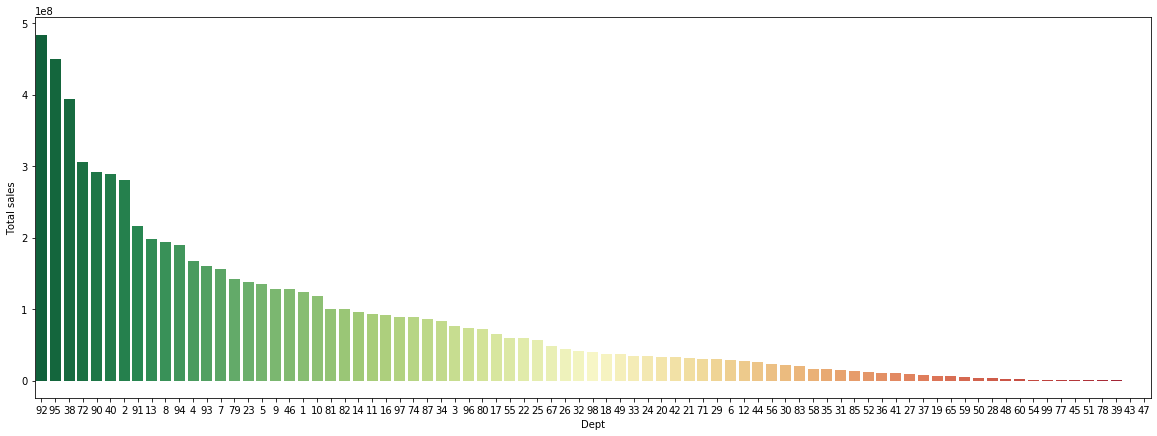

In [25]:
plt.figure(figsize=(20,7))
sns.barplot(sales_by_dept["Dept"],sales_by_dept["Total sales"],order=sales_by_dept["Dept"].tolist(),palette="RdYlGn_r")
plt.show()

In [26]:
sales_by_dept["Cum Sales"]=sales_by_dept["Total sales"].cumsum()
sales_by_dept["Pct sales"]=sales_by_dept["Cum Sales"]/train["Weekly_Sales"].sum()
dept_eighty_pct_sales=sales_by_dept[sales_by_dept["Pct sales"]<=0.81]["Dept"].tolist()
print("The first {0} departaments plotted represents the 80% of the total sales".format(len(dept_eighty_pct_sales)))

The first 29 departaments plotted represents the 80% of the total sales


In [27]:
train.groupby("Dept")["Weekly_Sales"].sum().reset_index(name="Sales by dept").set_index("Dept").describe()

,Sales by dept
count,8.100000e+01
mean,8.317554e+07
std,1.035439e+08
min,-4.962930e+03
25%,1.208694e+07
50%,3.982892e+07
75%,1.178974e+08
max,4.839433e+08


### 1.3.3 - Date and IsHoliday

In [28]:
sales_by_date=train.groupby("Date")["Weekly_Sales"].sum().reset_index(name="Sales")

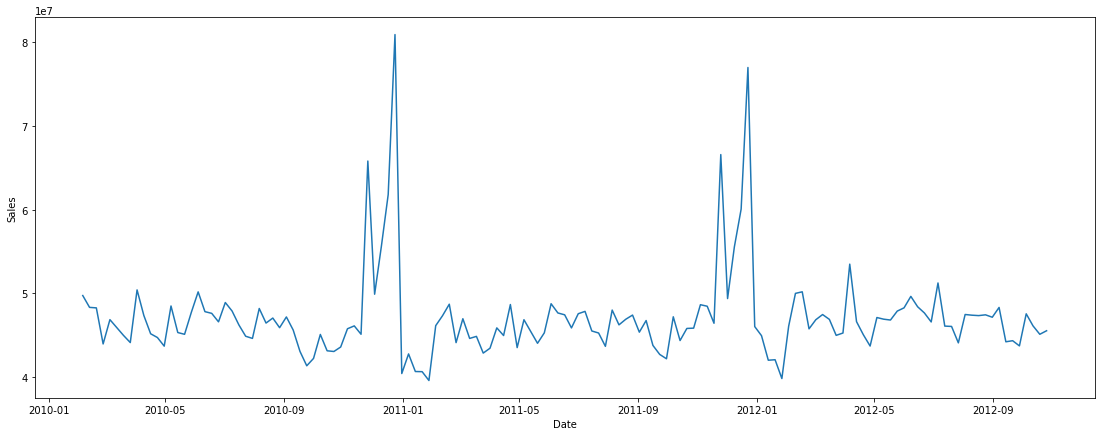

In [29]:
plt.figure(figsize=(19,7))
sns.lineplot(sales_by_date["Date"],sales_by_date["Sales"])
plt.show()

In [30]:
train["Date"].dt.weekday.unique()

array([4])

- They give us the weekly sales every Friday.
- Sales have not changed between years.

This for creates a column for each attribute of the date.

In [31]:
dt_cols=["Year","Day","Month","dayofweek",
         "weekofyear","weekday","Week","dayofyear","quarter",
         "is_month_start","is_month_end","is_quarter_start","is_quarter_end","is_year_start","is_year_end"]

for col in dt_cols:
    train[col]=getattr(train["Date"].dt, col.lower())
    test[col]=getattr(test["Date"].dt, col.lower())

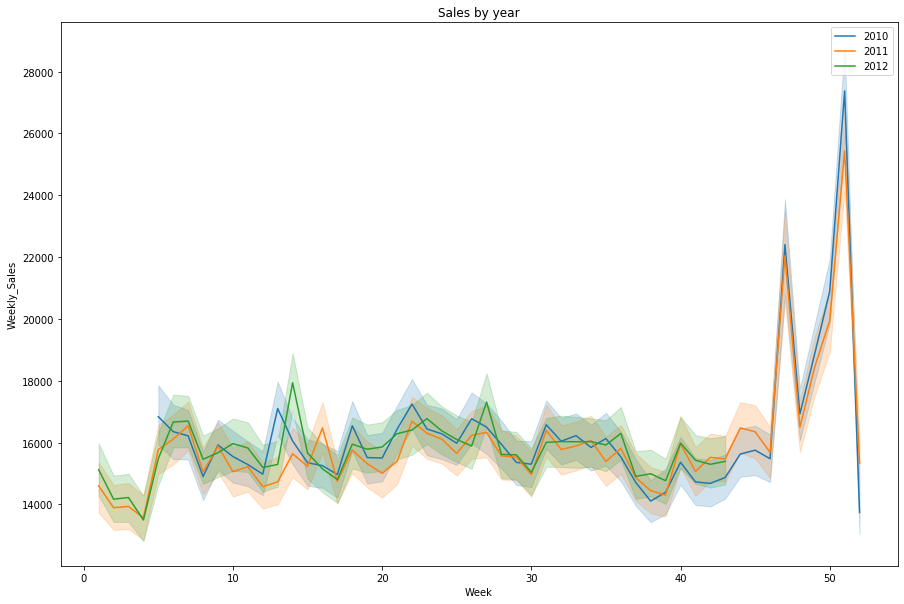

In [32]:
plt.figure(figsize=(15,10))
sns.lineplot(train[train["Year"]==2010]["Week"],train[train["Year"]==2010]["Weekly_Sales"],label="2010")
sns.lineplot(train[train["Year"]==2011]["Week"],train[train["Year"]==2011]["Weekly_Sales"],label="2011")
sns.lineplot(train[train["Year"]==2012]["Week"],train[train["Year"]==2012]["Weekly_Sales"],label="2012")
plt.title("Sales by year")
plt.legend()
plt.show()

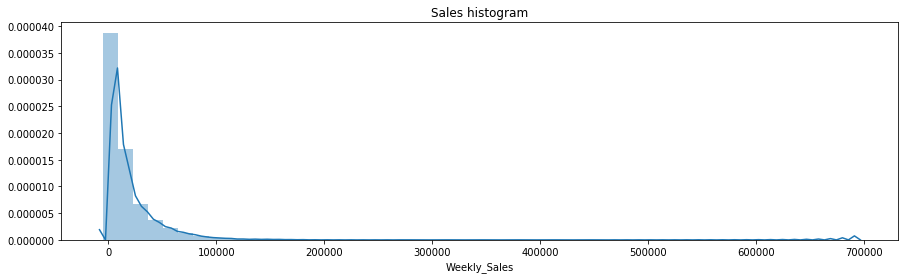

We see a target with a high skeweness


In [33]:
plt.figure(figsize=(15,4))
sns.distplot(train["Weekly_Sales"])
plt.title("Sales histogram")
plt.show()
print("We see a target with a high skeweness")

In [34]:
holiday_sales=train[train["IsHoliday"]==1].groupby("Date")["Weekly_Sales"].sum().reset_index(name="Sales on holidays")

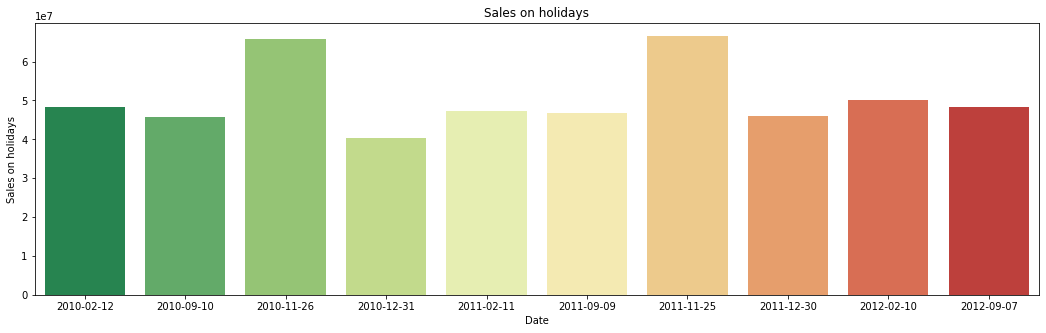

In [35]:
plt.figure(figsize=(18,5))
sns.barplot(holiday_sales["Date"].dt.date,holiday_sales["Sales on holidays"],palette="RdYlGn_r")
plt.title("Sales on holidays")
plt.show()

There are more important the weeks before holidays, so lets plot them.

In [36]:
holiday_sales["Week before holiday"]=holiday_sales["Date"].dt.date-pd.DateOffset(weeks=1)
holiday_sales["Sales week before holiday"]=train[train["Date"].isin(holiday_sales["Week before holiday"])].groupby("Date")["Weekly_Sales"].sum().reset_index(name="sales")["sales"]

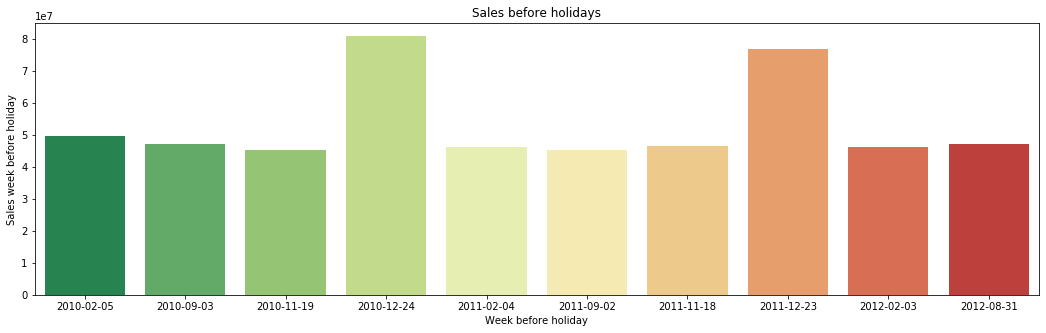

In [37]:
plt.figure(figsize=(18,5))
sns.barplot(holiday_sales["Week before holiday"].dt.date,holiday_sales["Sales week before holiday"],palette="RdYlGn_r")
plt.title("Sales before holidays")
plt.show()

## 1.4 - Numeric features

### 1.4.1 - Temperature

Each Store is in a different place, so stores has different Tª in the same day. So lets take the mean for all days and plot them

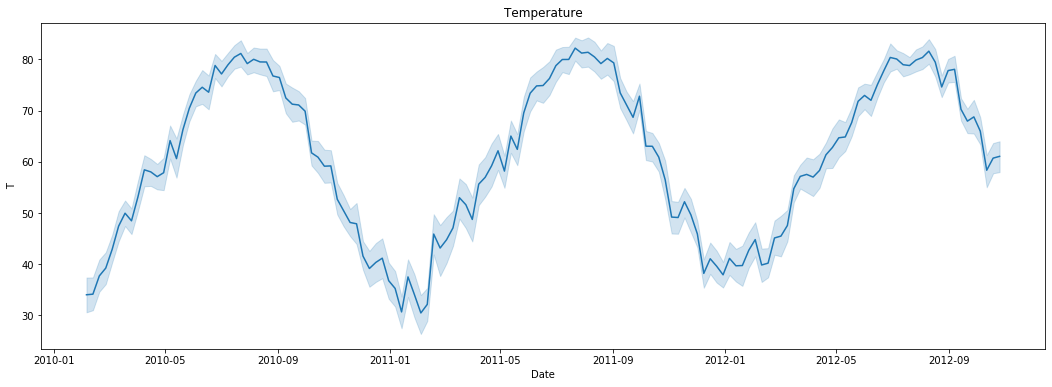

In [38]:
plt.figure(figsize=(18,6))
sns.lineplot(train.groupby(["Date","Store"])["Temperature"].mean().reset_index(name="T")["Date"],
             train.groupby(["Date","Store"])["Temperature"].mean().reset_index(name="T")["T"])
plt.title("Temperature")
plt.show()

In [39]:
train["Temperature"].describe()

count    421570.000000
mean         60.090059
std          18.447931
min          -2.060000
25%          46.680000
50%          62.090000
75%          74.280000
max         100.140000
Name: Temperature, dtype: float64

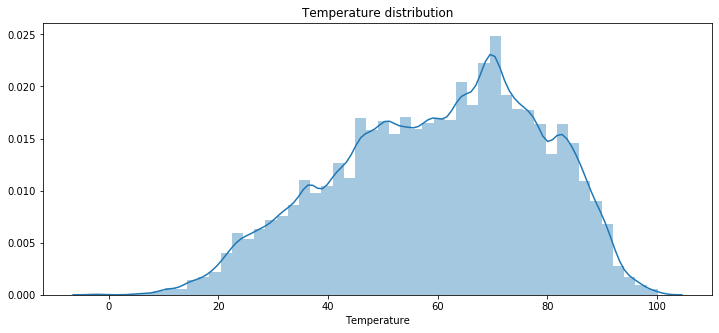

I made this graphic because I was only curious to see it. It adds nothing relevant to the analysis


In [40]:
plt.figure(figsize=(12,5))
sns.distplot(train["Temperature"])
plt.title("Temperature distribution")
plt.show()

print("I made this graphic because I was only curious to see it. It adds nothing relevant to the analysis")

### 1.4.2 - Fuel_Price

Also, the Fuel_Price varies depending the store and the date, so we take the mean to plot.

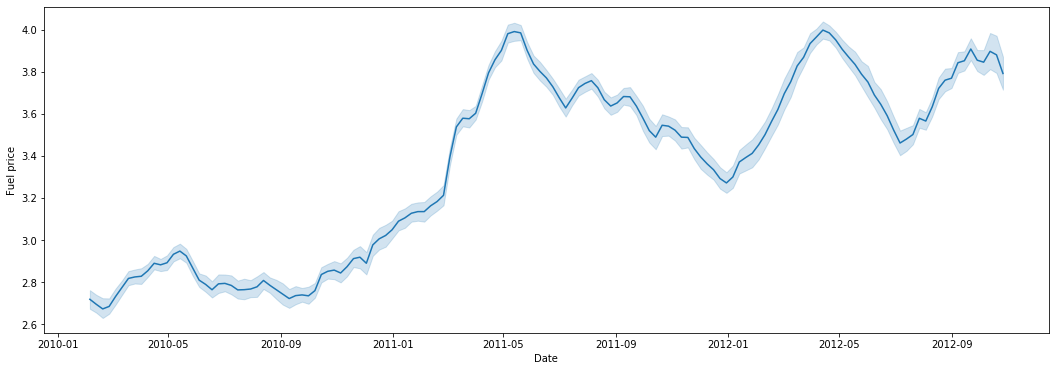

In [41]:
plt.figure(figsize=(18,6))
sns.lineplot(train.groupby(["Date","Store"])["Fuel_Price"].mean().reset_index(name="Fuel price")["Date"],
            train.groupby(["Date","Store"])["Fuel_Price"].mean().reset_index(name="Fuel price")["Fuel price"])
plt.show()

### 1.4.3 - CPI and unemployment

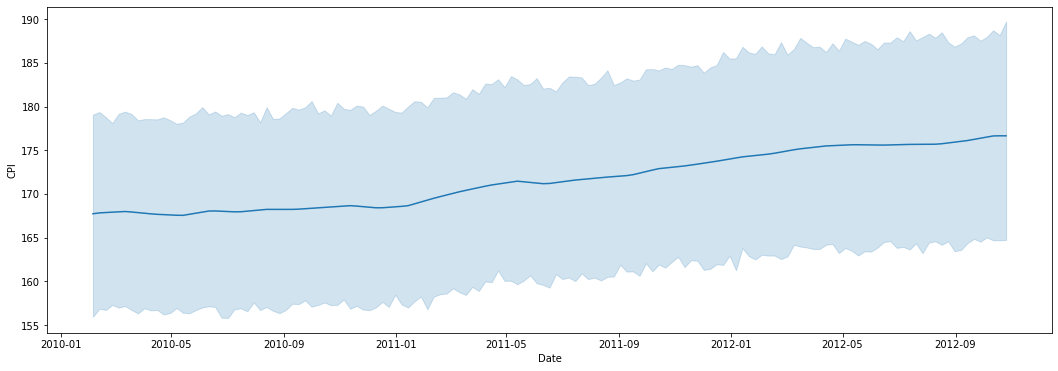

In [42]:
plt.figure(figsize=(18,6))
sns.lineplot(train.groupby(["Date","Store"])["CPI"].mean().reset_index(name="CPI")["Date"],
            train.groupby(["Date","Store"])["CPI"].mean().reset_index(name="CPI")["CPI"])
plt.show()

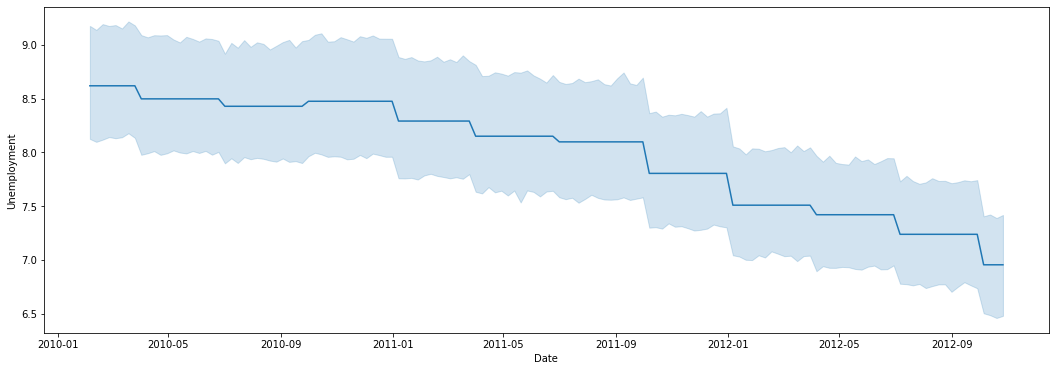

In [43]:
plt.figure(figsize=(18,6))
sns.lineplot(train.groupby(["Date","Store"])["Unemployment"].mean().reset_index(name="Unemployment")["Date"],
            train.groupby(["Date","Store"])["Unemployment"].mean().reset_index(name="Unemployment")["Unemployment"])
plt.show()

- The CPI is growing and the Unemployment is falling.
- The stores have differents CPI and Unemployments rates.

### 1.4.4 - Markdown
***MarkDown1-5:*** anonymized data related to promotional markdowns that Walmart is running. MarkDown data is only available after Nov 2011, and is not available for all stores all the time. Any missing value is marked with an NA.

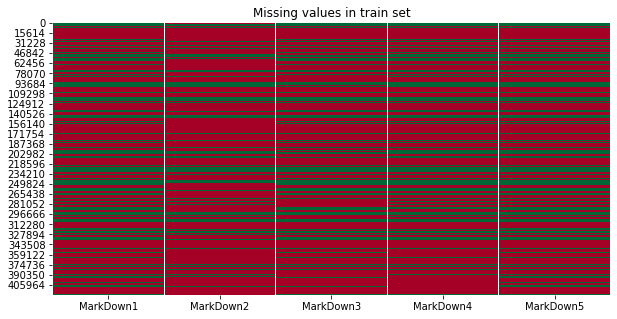

Percentage of missing values
MarkDown1    64.257181
MarkDown2    73.611025
MarkDown3    67.480845
MarkDown4    67.984676
MarkDown5    64.079038
dtype: float64


In [44]:
plt.figure(figsize=(10,5))
sns.heatmap(train[["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]].isnull(),cbar=False,cmap="RdYlGn_r")
plt.title("Missing values in train set")
plt.show()

print("Percentage of missing values")
print(train[["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]].isna().sum()/len(train)*100)


In [45]:
print("There are {0} rows with some MarkDown negative".format(
    
    len(train[(train["MarkDown1"]<0) | (train["MarkDown2"]<0) | 
        (train["MarkDown3"]<0) | (train["MarkDown4"]<0) |
        (train["MarkDown5"]<0)])
))

There are 1568 rows with some MarkDown negative


- I will create a new feature TotalMarkDown.
- After runnning model, this can be a feature to tune.

### 1.4.5 - Correlations and conclusions

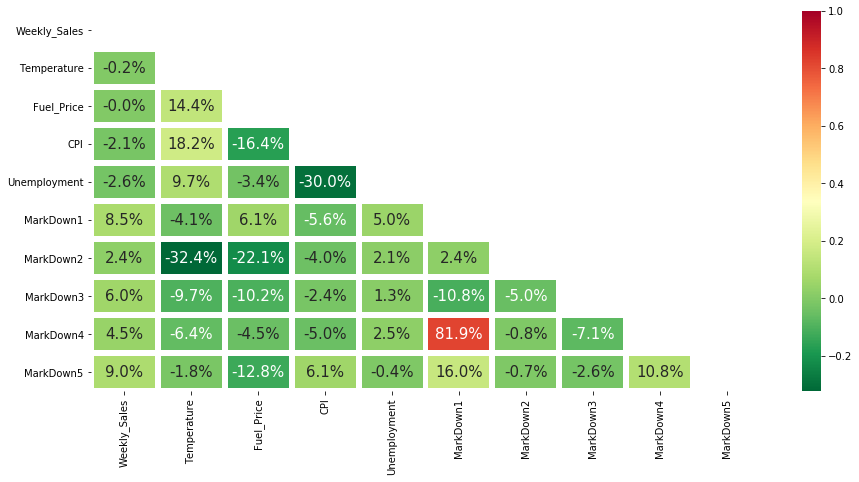

In [46]:
corr=train[["Weekly_Sales","Temperature","Fuel_Price","CPI","Unemployment",
            "MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]].corr()

plt.figure(figsize=(15,7))
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr,cmap="RdYlGn_r",annot=True,linewidths=5,mask=mask,fmt = '.1%',annot_kws={"size": 15})
plt.show()

- Temperature, fuel price are features that don't depend of the organization, and we saw that they are uncorrelated with the sales.

- Despite the fact that CPI has increased and Unemployment has decreased, the sales has decreased a bit, so the correlation is negative in both cases.

## 1.5 - Preprocessing

### 1.5.1 - Missing values

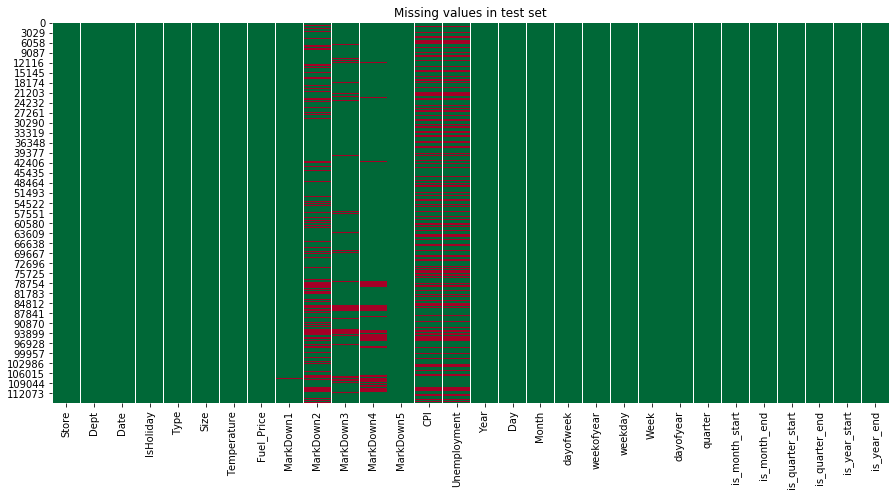

In [47]:
plt.figure(figsize=(15,7))
sns.heatmap(test.isnull(),cbar=False,cmap="RdYlGn_r")
plt.title("Missing values in test set")
plt.show()

#### 1.5.1.1 Markdowns
Filled with 0 and added a missing flag

In [48]:
markdowns_cols=["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]
for col in markdowns_cols:
    train[col+"_NaN"]=train[col].isnull()
    test[col+"_NaN"]=test[col].isnull()

In [49]:
train[["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]]=train[["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]].copy().fillna(0)
test[["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]]=test[["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"]].copy().fillna(0)

#### 1.5.1.2 CPI and Unemployment
For this features we needn't a flag, their are going to be filled with a IterativeImputer using a regression.

In [50]:
imputer=IterativeImputer(estimator=BayesianRidge(),random_state=26)
imputed_values=imputer.fit_transform(test[["Store","Dept","Year","Month","quarter","CPI","Unemployment"]])

In [51]:
test[["CPI","Unemployment"]]=imputed_values[:,[5,6]]

### 1.5.2 Categorical features

In [52]:
train["Type"]=train["Type"].astype("category")
test["Type"]=test["Type"].astype("category")

In [53]:
train["Type"].cat.codes

0         0
1         0
2         0
3         0
4         0
         ..
421565    1
421566    1
421567    1
421568    1
421569    1
Length: 421570, dtype: int8

In [54]:
train["Type"]=train["Type"].cat.codes
test["Type"]=test["Type"].cat.codes

# 2. Baseline model

Once I've the data analyzed and no missing values, I'm going to create a tree-based model in order to have a baseline score. From there I will tune the hyper-parameters to adjust the model and later I will create new features to improve the score.

With tree based models there is no need to make a scaling to numeric features

The competition evaluate with a Weighted Mean Abs Error, if it's a holiday weight=5, else =1.


Here is the function that calculates that score


In [55]:
def WMAE(Y_test,Y_pred,X_test):
    weights=np.where(X_test["IsHoliday"]==1,5,1)
    WMAE=sum(weights*abs(Y_test-Y_pred))
    WMAE=WMAE/sum(weights)
    print("WMAE = {0}".format(WMAE))

In [56]:
train=train.sort_values(by=["Year","Month","Day"])
X=train.drop(["Weekly_Sales","Date"],axis=1)
Y=train["Weekly_Sales"]
X.shape, Y.shape

((421570, 34), (421570,))

We have to split the sets in time order

In [57]:
X_train=X.loc[:len(X)*0.7,:]
X_test=X.loc[len(X)*0.7:,:]
Y_train=Y.loc[:len(Y)*0.7]
Y_test=Y.loc[len(Y)*0.7:]

In [58]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((320016, 34), (101555, 34), (320016,), (101555,))

In [59]:
baseline=RandomForestRegressor(n_estimators=15)
%time baseline.fit(X_train,Y_train)

CPU times: user 1min 10s, sys: 290 ms, total: 1min 10s
Wall time: 1min 10s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=15, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [61]:
Y_pred=baseline.predict(X_test)

In [62]:
WMAE(Y_test,Y_pred,X_test)

WMAE = 1933.0638856334972


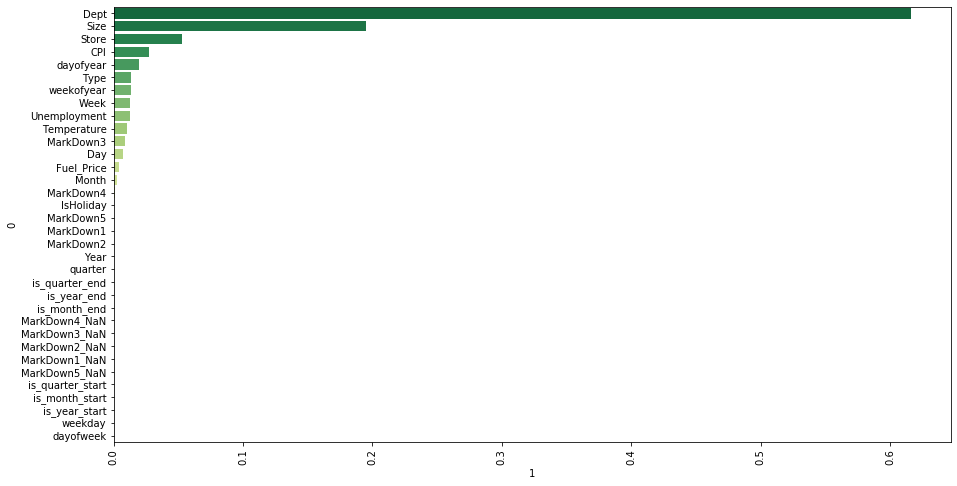

In [63]:
feature_imp=pd.DataFrame(list(zip(X.columns,baseline.feature_importances_))).sort_values(by=1,ascending=False)
plt.figure(figsize=(15,8))
sns.barplot(feature_imp[1],feature_imp[0],palette="RdYlGn_r",orient="h")
plt.xticks(rotation=90)
plt.show()

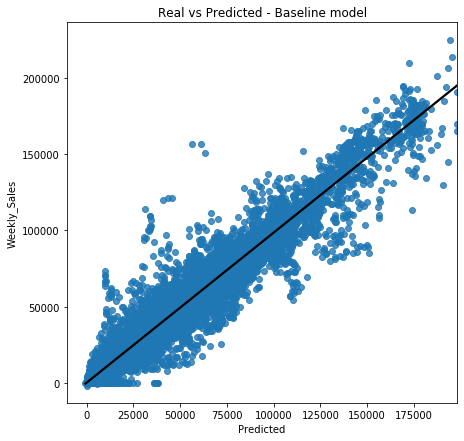

In [64]:
plt.figure(figsize=(7,7))
sns.regplot(Y_pred,Y_test, line_kws={"color":"k"})
plt.ylabel("Weekly_Sales")
plt.xlabel("Predicted")
plt.title("Real vs Predicted - Baseline model")
plt.show()

- Next, I will create a few new features and try to delete those who hasn't much importance.

# 3. Feature creation

## 3.1 Week before holiday
As we saw on the graphics in 1.3.3 section, the people buy before holidays, so a good indicator might be this one

In [65]:
train["WeekHoliday"]=train["IsHoliday"].shift(-1)
train["WeekHoliday"].fillna(0,inplace=True)
train["WeekHoliday"]=train["WeekHoliday"].astype(int)

test["WeekHoliday"]=test["IsHoliday"].shift(-1)
test["WeekHoliday"].fillna(0,inplace=True)
test["WeekHoliday"]=test["WeekHoliday"].astype(int)

## 3.2 Total Markdown

In [66]:
train["TotalMarkdown"]=train["MarkDown1"]+train["MarkDown2"]+train["MarkDown3"]+train["MarkDown4"]+train["MarkDown5"]
test["TotalMarkdown"]=test["MarkDown1"]+test["MarkDown2"]+test["MarkDown3"]+test["MarkDown4"]+test["MarkDown5"]

In [67]:
train.drop(["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"],axis=1,inplace=True)

In [68]:
test.drop(["MarkDown1","MarkDown2","MarkDown3","MarkDown4","MarkDown5"],axis=1,inplace=True)

## 3.3 Size type

A new characteristic to each store based on their size

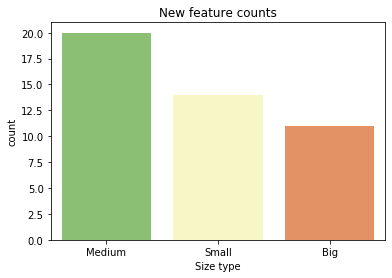

In [69]:
big_size=train["Size"].quantile(0.75)
small_size=train["Size"].quantile(0.25)
train["Size type"]=np.where(train["Size"]>=big_size,"Big",np.where(train["Size"]>small_size,"Medium","Small"))
test["Size type"]=np.where(test["Size"]>=big_size,"Big",np.where(test["Size"]>small_size,"Medium","Small"))
sns.countplot(train.groupby("Store")["Size type"].value_counts().reset_index(name="N").iloc[:,1],palette="RdYlGn_r")
plt.title("New feature counts")
plt.show()

In [70]:
train["Size type"]=train["Size type"].astype("category")
test["Size type"]=test["Size type"].astype("category")
train["Size type"]=train["Size type"].cat.codes
test["Size type"]=test["Size type"].cat.codes

# 4. Model with new features

In [71]:
train=train.sort_values(by=["Year","Month","Day"])
X=train.drop(["Weekly_Sales","Date"],axis=1)
Y=train["Weekly_Sales"]
X.shape, Y.shape

((421570, 32), (421570,))

In [72]:
X_train=X.loc[:len(X)*0.7,:]
X_test=X.loc[len(X)*0.7:,:]
Y_train=Y.loc[:len(Y)*0.7]
Y_test=Y.loc[len(Y)*0.7:]

In [73]:
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((320016, 32), (101555, 32), (320016,), (101555,))

In [74]:
forest2=RandomForestRegressor(n_estimators=15)
%time forest2.fit(X_train,Y_train)

CPU times: user 1min 6s, sys: 303 ms, total: 1min 6s
Wall time: 1min 6s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=15, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [75]:
Y_pred=forest2.predict(X_test)
WMAE(Y_test,Y_pred,X_test)

WMAE = 1945.7786836185714


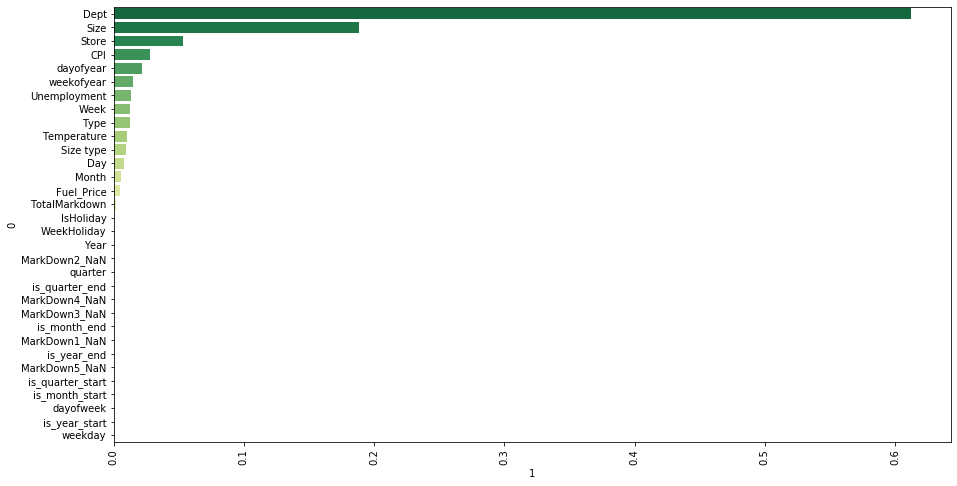

In [76]:
feature_imp=pd.DataFrame(list(zip(X.columns,forest2.feature_importances_))).sort_values(by=1,ascending=False)
plt.figure(figsize=(15,8))
sns.barplot(feature_imp[1],feature_imp[0],palette="RdYlGn_r",orient="h")
plt.xticks(rotation=90)
plt.show()

Now I'm checking if removing the lest importante features improves the model

In [77]:
feature_imp["cumsum"]=feature_imp[1].cumsum()

In [78]:
feature_imp

,0,1,cumsum
1,Dept,0.612031,0.612031
4,Size,0.188417,0.800448
0,Store,0.053459,0.853906
7,CPI,0.027604,0.881510
16,dayofyear,0.022071,0.903581
13,weekofyear,0.015131,0.918712
8,Unemployment,0.013062,0.931774
15,Week,0.012662,0.944436
3,Type,0.012537,0.956973
5,Temperature,0.010558,0.967531


In [79]:
features_selected=feature_imp[feature_imp["cumsum"]<=0.999200][0]
features_selected

1              Dept
4              Size
0             Store
7               CPI
16        dayofyear
13       weekofyear
8      Unemployment
15             Week
3              Type
5       Temperature
31        Size type
10              Day
11            Month
6        Fuel_Price
30    TotalMarkdown
2         IsHoliday
29      WeekHoliday
9              Year
Name: 0, dtype: object

In [80]:
forest3=RandomForestRegressor(n_estimators=15)
%time forest3.fit(X_train[features_selected],Y_train)

CPU times: user 59.4 s, sys: 299 ms, total: 59.7 s
Wall time: 59.7 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=15, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [81]:
Y_pred=forest3.predict(X_test[features_selected])
WMAE(Y_test,Y_pred,X_test[features_selected])

WMAE = 1974.0133111853613


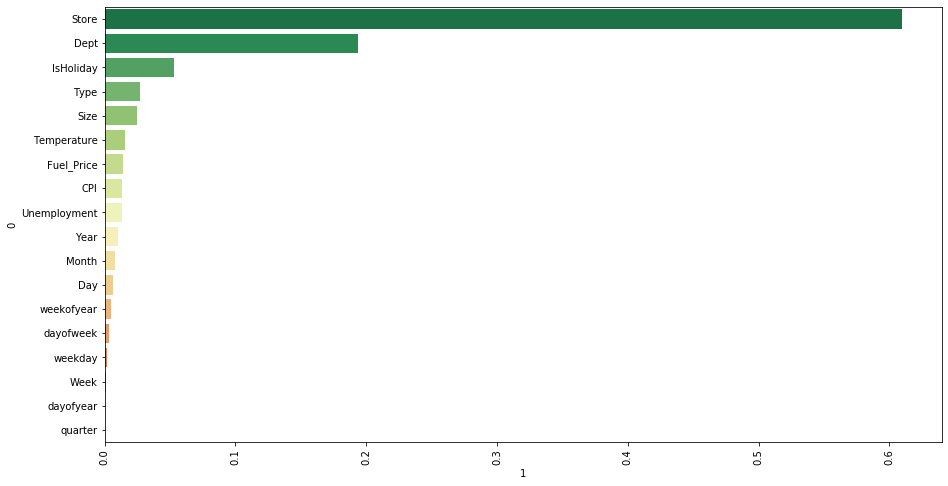

In [83]:
feature_imp=pd.DataFrame(list(zip(X.columns,forest3.feature_importances_))).sort_values(by=1,ascending=False)
plt.figure(figsize=(15,8))
sns.barplot(feature_imp[1],feature_imp[0],palette="RdYlGn_r",orient="h")
plt.xticks(rotation=90)
plt.show()

The model score improves with the new features and with the feature selection.

# 5. Hyper-parameter tunning

- I dont have a powerful computer, so I wasn't able to do a GridSearchCV and also to do Cross-Validation.
- In case of having a more powerful computer, we have to to do a GridSearchCV but its very important to do a TimeSplit crossvalidation.
- Subsamples isn't a good idea because we only have two years, and holidays are very important, also the year end.
- The idea was model a Random Forest, but the time that was taking was too long, so I decided to create a model with XGBRegressor

In [84]:
forest_final=RandomForestRegressor(n_estimators=42,max_features=0.7)
%time forest_final.fit(X_train[features_selected],Y_train)

CPU times: user 1min 42s, sys: 832 ms, total: 1min 43s
Wall time: 1min 44s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features=0.7, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=42, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [85]:
Y_pred=forest_final.predict(X_test[features_selected])
WMAE(Y_test,Y_pred,X_test[features_selected])

WMAE = 1788.3105330928752


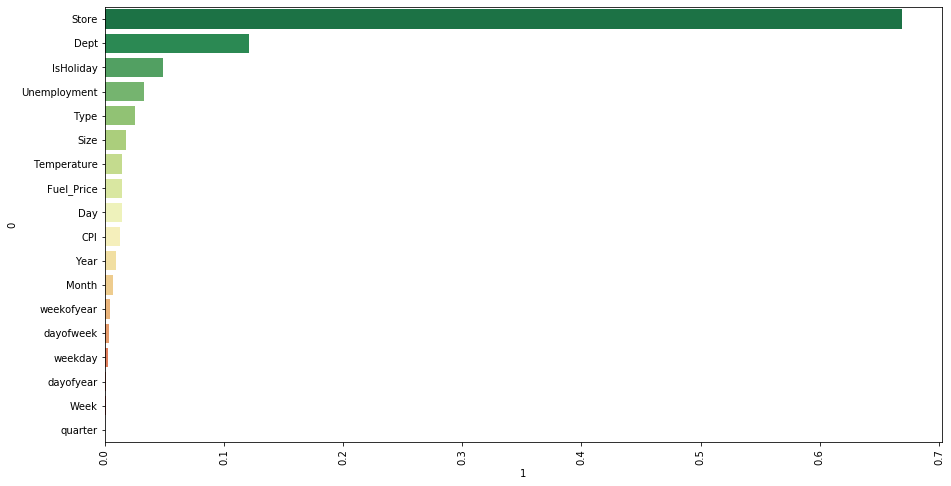

In [86]:
feature_imp=pd.DataFrame(list(zip(X.columns,forest_final.feature_importances_))).sort_values(by=1,ascending=False)
plt.figure(figsize=(15,8))
sns.barplot(feature_imp[1],feature_imp[0],palette="RdYlGn_r",orient="h")
plt.xticks(rotation=90)
plt.show()

# 6. Submission

In [87]:
submission["Weekly_Sales"]=forest_final.predict(test[features_selected])

In [88]:
submission.to_csv("mysubmission.csv",index=False)